In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
else: plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
DATA_PATH = "./data/dataset_manual_cleaned.csv"

try:
    df = pd.read_csv(DATA_PATH)
    
    # [1] 유령 행 삭제 (제목 없는 것 제거)
    df = df.dropna(subset=['title'])
    
    # [2] Source + Category 통합 (Merge)
    # category에 값이 있으면 source의 빈칸을 그걸로 채움 (Combine)
    if 'category' in df.columns:
        df['source'] = df['source'].fillna(df['category'])
        # 통합 완료 후 category 컬럼 삭제 (깔끔하게 source 하나로 통일)
        df = df.drop(columns=['category'])
    
    df['source'] = df['source'].fillna('Unknown')
    
    # [3] 라벨 정수 변환
    df['label_relevance'] = df['label_relevance'].fillna(-1).astype(int)
    df['label_importance'] = df['label_importance'].fillna(-1).astype(int)

    # [4] 본문 빈값 처리 (중요!)
    # NaN을 빈 문자열("")로 바꿈 -> 이제 info()에서는 Non-Null로 뜸
    df['content'] = df['content'].fillna("")
    
    # [출력] 자네가 원한 포맷
    print(f"원본 데이터 개수: {len(df)}")
    
    # 제목이나 본문이 NaN인 개수 (fillna 했으므로 0이 나옴)
    missing_count = df[['title', 'content']].isnull().sum().sum()
    print(f"결측치(제목 + 본문): {missing_count}")
    
    # (참고용) 진짜 내용이 빈 공지의 개수 확인
    empty_content_count = len(df[df['content'] == ""])
    print(f"   * 참고: 본문 내용이 공란인 데이터: {empty_content_count}개")
    
    display(df.head(3))
    
except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. (경로: {DATA_PATH})")

원본 데이터 개수: 1355
결측치(제목 + 본문): 0
   * 참고: 본문 내용이 공란인 데이터: 83개


,label_relevance,label_importance,title,content,date,link,source
0,1,1,e-Class 서비스 일시 중단 안내,e-Class 서비스 일시 중단 안내 안정적인 정보서비스 제공을 위해 아래 일정으로...,2025.11.19,https://www.hufs.ac.kr/bbs/hufs/2180/242999/ar...,공지(일반)
1,0,0,2025학년도 동계방학 HUFS Dorm 사생 모집안내,[2025학년도 동계방학 HUFS Dorm 사생 모집] 1. 신청대상 : 2025학...,2025.11.03,https://www.hufs.ac.kr/bbs/hufs/2180/241843/ar...,공지(일반)
2,1,0,교내 건물별 난방기준 안내,교내 건물별 난방기준 안내 1. 난방기준 온도 : 외기온도 5℃ 이하(기상청 자동예...,2025.11.10,https://www.hufs.ac.kr/bbs/hufs/2180/242275/ar...,공지(일반)


In [2]:
print("=== [1] 데이터 컬럼 및 타입 정보 (df.info) ===")
# category는 삭제되고 source로 통합되었으므로 source만 나오는 게 맞습니다.
df.info()

print("\n=== [2] 라벨별 데이터 개수 (Label Counts) ===")

# 깔끔한 표(DataFrame) 형태 출력
relevance_counts = df['label_relevance'].value_counts().sort_index().to_frame(name='개수')
importance_counts = df['label_importance'].value_counts().sort_index().to_frame(name='개수')

print("\n[관련도 (Relevance)]")
display(relevance_counts)

print("\n[중요도 (Importance)]")
display(importance_counts)

=== [1] 데이터 컬럼 및 타입 정보 (df.info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label_relevance   1355 non-null   int64 
 1   label_importance  1355 non-null   int64 
 2   title             1355 non-null   object
 3   content           1355 non-null   object
 4   date              1355 non-null   object
 5   link              1355 non-null   object
 6   source            1355 non-null   object
dtypes: int64(2), object(5)
memory usage: 74.2+ KB

=== [2] 라벨별 데이터 개수 (Label Counts) ===

[관련도 (Relevance)]


,개수
label_relevance,
0,570
1,785



[중요도 (Importance)]


,개수
label_importance,
0,948
1,284
2,123


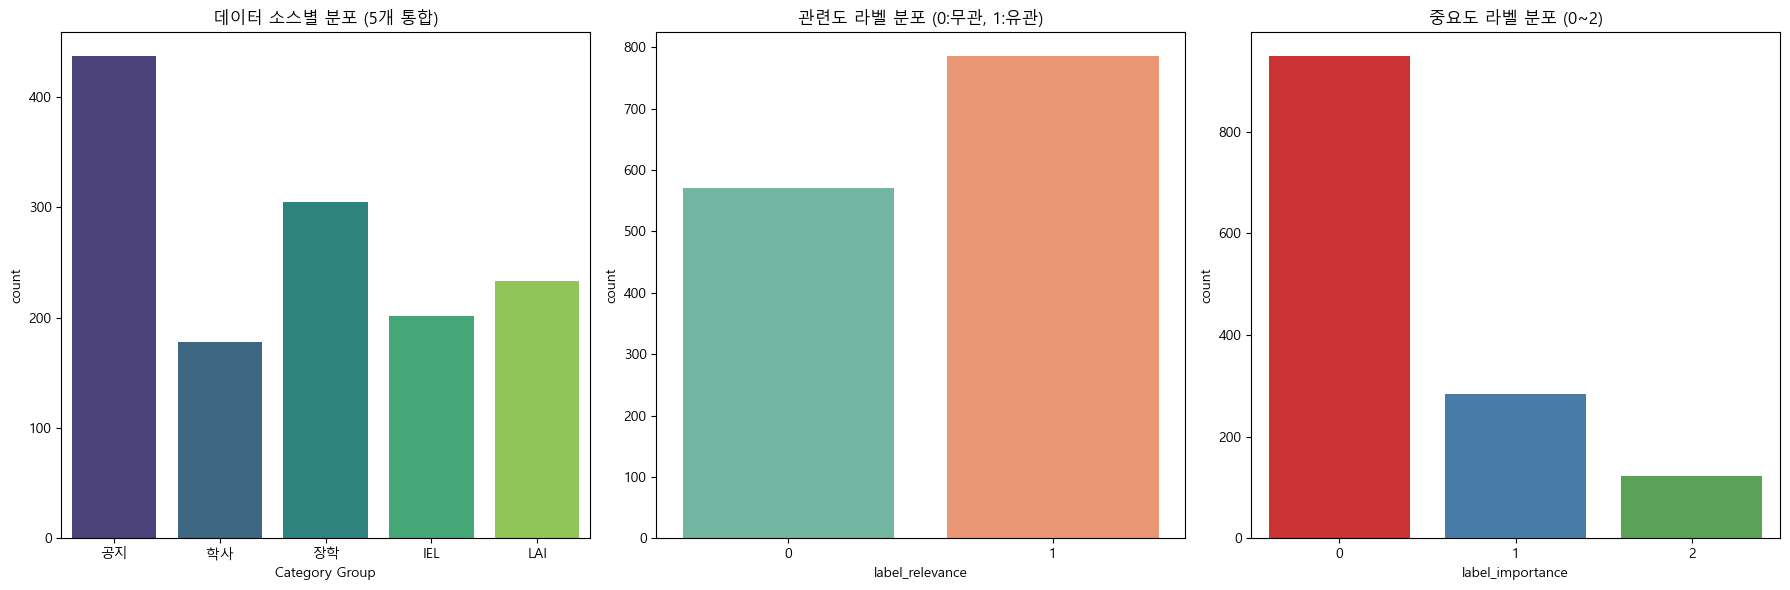

In [3]:
# === 소스 그룹핑 (Mapping) ===
# 복잡한 소스명을 5개 대분류로 통합
source_mapping = {
    '공지(일반)': '공지',
    '학사': '학사',
    '장학': '장학',
    'IEL_공지': 'IEL',
    'IEL_자유': 'IEL',
    'LAI_공지': 'LAI',
    'LAI_소식': 'LAI'
}

# 새로운 컬럼 'category_group' 생성
df['category_group'] = df['source'].map(source_mapping)

# 시각화
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. 소스별 데이터 개수 (그룹핑 적용 & 경고 해결)
sns.countplot(
    x='category_group', 
    data=df, 
    ax=ax[0], 
    palette='viridis', 
    hue='category_group',  # 경고 해결: x와 동일한 변수 지정
    legend=False,          # 경고 해결: 범례 숨김
    order=['공지', '학사', '장학', 'IEL', 'LAI'] # 순서 지정
)
ax[0].set_title('데이터 소스별 분포 (5개 통합)')
ax[0].set_xlabel('Category Group')

# 2. 관련도 라벨 분포
sns.countplot(
    x='label_relevance', 
    data=df, 
    ax=ax[1], 
    palette='Set2', 
    hue='label_relevance', 
    legend=False
)
ax[1].set_title('관련도 라벨 분포 (0:무관, 1:유관)')

# 3. 중요도 라벨 분포
sns.countplot(
    x='label_importance', 
    data=df, 
    ax=ax[2], 
    palette='Set1', 
    hue='label_importance', 
    legend=False
)
ax[2].set_title('중요도 라벨 분포 (0~2)')

plt.tight_layout()
plt.show()

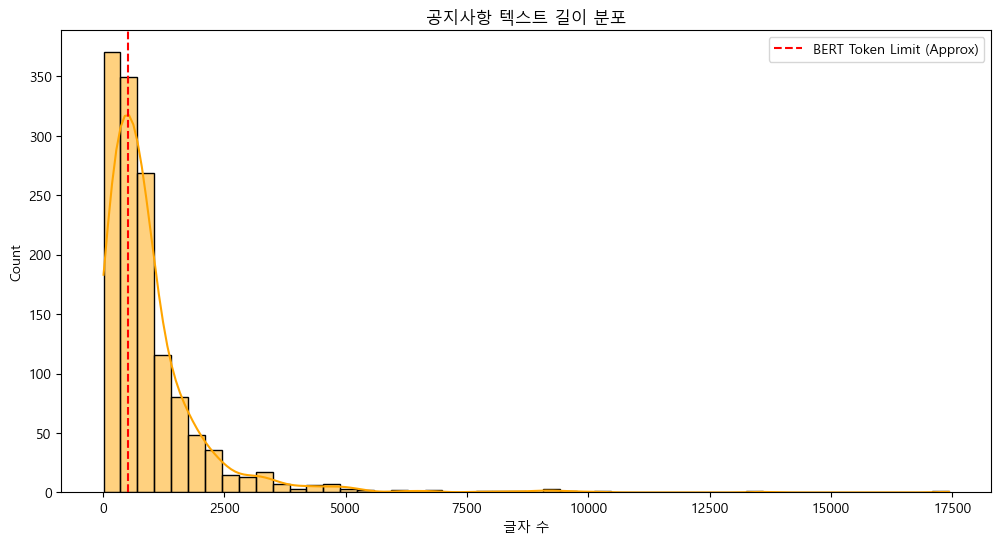

평균 길이: 968.3
중간값 길이: 663.0


In [4]:
# 제목+본문 길이 계산
df['text_len'] = df['title'].astype(str).apply(len) + df['content'].astype(str).apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df['text_len'], bins=50, kde=True, color='orange')
plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (Approx)')
plt.title('공지사항 텍스트 길이 분포')
plt.xlabel('글자 수')
plt.legend()
plt.show()

print(f"평균 길이: {df['text_len'].mean():.1f}")
print(f"중간값 길이: {df['text_len'].median():.1f}")